In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch
import numpy as np
from plyfile import PlyData
import json 
device = torch.device("cuda:0")

In [2]:
PLY_PATH = "/home/ubuntu/workdir/gsplat/DATA/alti/splat.ply"
ply_data = PlyData.read(PLY_PATH)
vertices = ply_data['vertex']

In [3]:
with open('/home/ubuntu/workdir/gsplat/DATA/alti/transforms.json', 'r') as f:
    transforms_data = json.load(f)

transform_matrix = [frame["transform_matrix"] for frame in transforms_data["frames"]]

In [4]:
points = np.stack((vertices['x'], vertices['y'], vertices['z']), axis=-1)
colors = np.stack((vertices['f_dc_0'], vertices['f_dc_1'], vertices['f_dc_2']), axis=-1)
scales = np.stack((vertices['scale_0'], vertices['scale_1'], vertices['scale_2']), axis=-1)
quats = np.stack((vertices['rot_0'], vertices['rot_1'], vertices['rot_2'], vertices['rot_3']), axis=-1)
opacities = vertices['opacity']

In [5]:
num_points_to_keep = 74986 - 73000

# means = means[-num_points_to_keep:]
# colors = colors[-num_points_to_keep:]
# scales = scales[-num_points_to_keep:]
# quats = quats[-num_points_to_keep:]
# opacities = opacities[-num_points_to_keep:]

In [6]:
means = torch.from_numpy(points[-num_points_to_keep:]).to(device)
scales = torch.from_numpy(scales[-num_points_to_keep:]).to(device) * 0.1
quats = torch.from_numpy(quats[-num_points_to_keep:]).to(device)
opacities = torch.from_numpy(opacities[-num_points_to_keep:]).to(device)
opacities = opacities.squeeze()

In [7]:
means.shape

torch.Size([4986, 3])

In [8]:
viewmats = torch.tensor(transform_matrix, dtype=torch.float32).to(device)
N = viewmats.shape[0]  # Assuming viewmats is [C, 4, 4]
Ks = torch.tensor([[319.0, 0.0, 320.0],
                    [0.0, 341.0, 320.0],
                    [0.0, 0.0, 1.0]]).unsqueeze(0).to(device=device)  # Single camera matrix
Ks = Ks.repeat(N, 1, 1)  
C = len(Ks)

colors = torch.from_numpy(colors[-num_points_to_keep:]).to(device)
colors = colors.unsqueeze(0).repeat(N, 1, 1)

In [9]:
width=480
height=360

In [10]:
def test_rasterize_to_pixels():
    from gsplat.experimental.cuda import _rendering, _rendering_gsplat, rendering, quat_scale_to_covar_perci, projection, isect_tiles, isect_offset_encode, rasterize_to_pixels
    
    viewmats.requires_grad = True
    quats.requires_grad = True
    scales.requires_grad = True
    means.requires_grad = True

    render_colors, render_alphas = _rendering(
        means, quats, scales, opacities, colors, viewmats, Ks, width, height
    )
    
    return render_colors, render_alphas

In [11]:
render_colors, render_alphs = test_rasterize_to_pixels()

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.42 GiB. GPU 0 has a total capacty of 39.38 GiB of which 4.62 GiB is free. Including non-PyTorch memory, this process has 34.75 GiB memory in use. Of the allocated memory 31.65 GiB is allocated by PyTorch, and 2.62 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
render_colors

tensor([[[[ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          ...,
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208]],

         [[ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          ...,
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208]],

         [[ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          ...,
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208]],

         ...,

         [[ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          ...,
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0.0519, -0.2208],
          [ 0.2883,  0

In [ ]:
render_colors.shape

torch.Size([929, 360, 480, 3])

In [ ]:
import matplotlib.pyplot as plt

first_image = render_colors[0].detach().cpu().numpy()

print("IMAGE SHAPE:", first_image.shape)


IMAGE SHAPE: (360, 480, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRANSPOSED: (360, 480, 3)


(-0.5, 479.5, 359.5, -0.5)

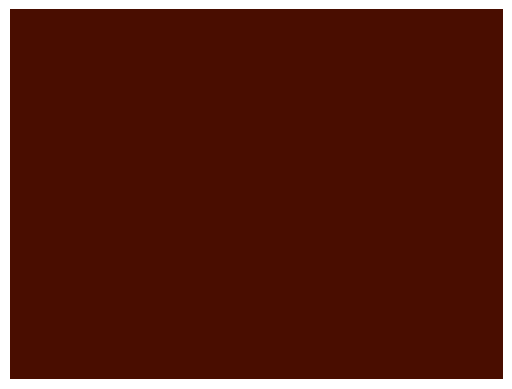

In [ ]:

# Transpose the image if needed (e.g., if it is in CHW format)
first_image = np.transpose(first_image, (0, 1, 2))  # Adjust transpose order based on your needs

# Print transposed shape
print("TRANSPOSED:", first_image.shape)

# Plot the transposed image
plt.imshow(first_image)
plt.axis('off')  # Turn off axis numbers and ticks